In [2]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
from multiprocessing import Pool
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from torchvision import transforms, models
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, LambdaLR
from sklearn.metrics import cohen_kappa_score
import timm
import copy



In [3]:
## for removing file if required
import shutil

try:
    shutil.rmtree("/kaggle/working/train")
    
    model_file_to_delete ="/kaggle/working/models"

    if os.path.isfile(model_file_to_delete):
        os.remove(model_file_to_delete)
    
except:
    print("No such directories")

No such directories


# Explatory Data Analysis
## Load Data

In [4]:
def load_data(data_dir):
    train_csv = os.path.join(data_dir, 'train.csv')
    test_csv = os.path.join(data_dir, 'test.csv')
    
    train = pd.read_csv(train_csv)
    test = pd.read_csv(test_csv)
    
    train_dir = os.path.join(data_dir, 'train_images/')
    test_dir = os.path.join(data_dir, 'test_images/')
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir, '{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir, '{}.png'.format(x)))
    
    train['file_name'] = train["id_code"] + ".png"
    test['file_name'] = test["id_code"] + ".png"
    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train, test

In [5]:
data_dir = '/kaggle/input/aptos2019-blindness-detection/'
train_df, test_df = load_data(data_dir)

## Data Shape, Distribution & Visualization

### shape

In [6]:
print(train_df.shape)
train_df.head()

(3662, 4)


,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,/kaggle/input/aptos2019-blindness-detection/tr...,000c1434d8d7.png
1,001639a390f0,4,/kaggle/input/aptos2019-blindness-detection/tr...,001639a390f0.png
2,0024cdab0c1e,1,/kaggle/input/aptos2019-blindness-detection/tr...,0024cdab0c1e.png
3,002c21358ce6,0,/kaggle/input/aptos2019-blindness-detection/tr...,002c21358ce6.png
4,005b95c28852,0,/kaggle/input/aptos2019-blindness-detection/tr...,005b95c28852.png


In [7]:
print(test_df.shape)
test_df.head()

(1928, 3)


,id_code,file_path,file_name
0,0005cfc8afb6,/kaggle/input/aptos2019-blindness-detection/te...,0005cfc8afb6.png
1,003f0afdcd15,/kaggle/input/aptos2019-blindness-detection/te...,003f0afdcd15.png
2,006efc72b638,/kaggle/input/aptos2019-blindness-detection/te...,006efc72b638.png
3,00836aaacf06,/kaggle/input/aptos2019-blindness-detection/te...,00836aaacf06.png
4,009245722fa4,/kaggle/input/aptos2019-blindness-detection/te...,009245722fa4.png


### distribution

In [8]:
def plot_dis_classes(df):
    df_group = df['diagnosis'].value_counts().reset_index()
    df_group.columns = ['diagnosis', 'count']

    plt.figure(figsize=(10, 5))
    plt.bar(df_group['diagnosis'], df_group['count'], color='skyblue')
    plt.xlabel('Diagnosis')
    plt.ylabel('Count')
    plt.title('Output Class Distribution')
    plt.show()

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64


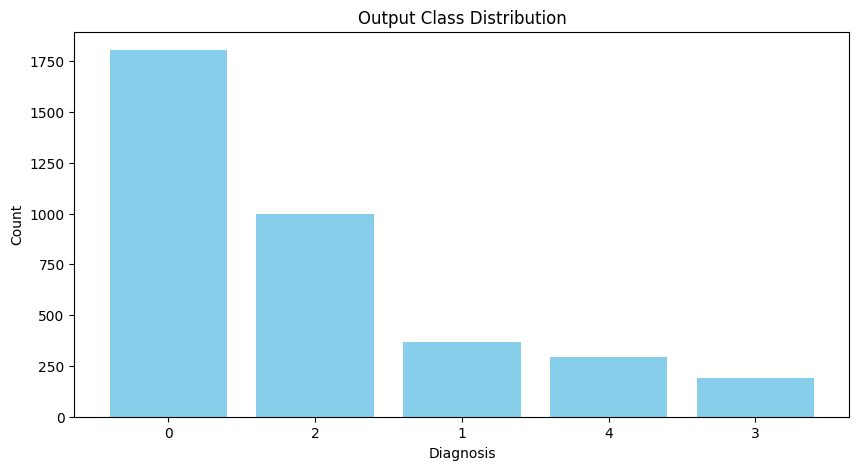

In [9]:
print(train_df['diagnosis'].value_counts())
plot_dis_classes(train_df)

#### Here we can see in the trainig images there is -
1. 1805 images of class 0 - No DR
2. 999 images of class 1 - Mild DR
3. 370 images of class 2 - Moderate DR
4. 295 images of class 3 - Severe DR, and
5. 193 images of class 4 - Proliferative DR

### visualization_function

In [10]:
def visualize_imgs(df, plots_per_class, color_scale, img_size):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(plots_per_class)).reset_index(drop=True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(plots_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (plots_per_class*0),pt + (plots_per_class*1), pt + (plots_per_class*2),pt + (plots_per_class*3),pt + (plots_per_class*4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = convert_to_gray(cv2.imread(df_temp.file_path.iloc[i]), img_size)
                axarr[i].imshow(img,cmap = color_scale)
            else: ## RGB
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((img_size,img_size)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

### Data Visulaization

/tmp/ipykernel_34/136394828.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(plots_per_class)).reset_index(drop=True)


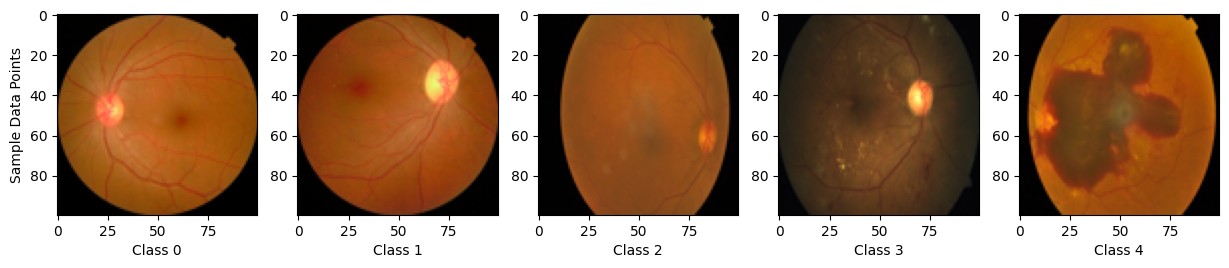

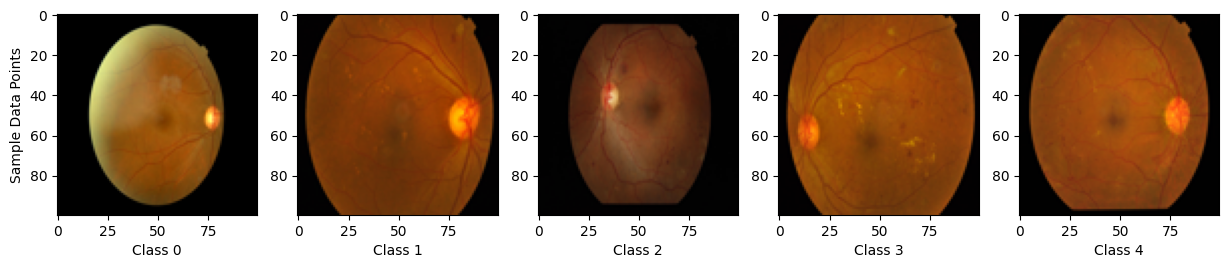

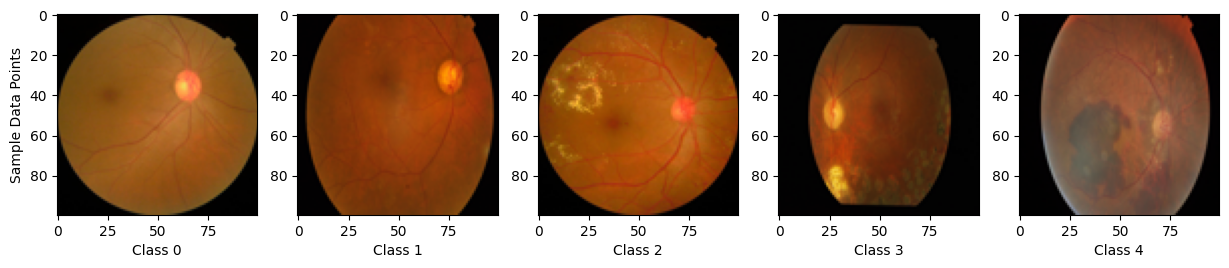

In [11]:
plots_per_class = 3
img_size = 100
visualize_imgs(train_df,plots_per_class,None, img_size)

#### As we can't differentiate much from this RGB images we will look into Grey Scale images for better differentiation.

In [12]:
## function to convert images into grey scale
def convert_to_gray(img, img_size):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (img_size,img_size))
    return img

/tmp/ipykernel_34/136394828.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(plots_per_class)).reset_index(drop=True)


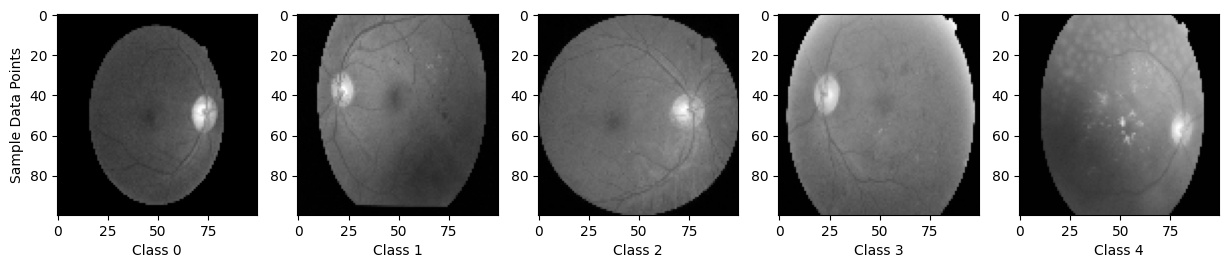

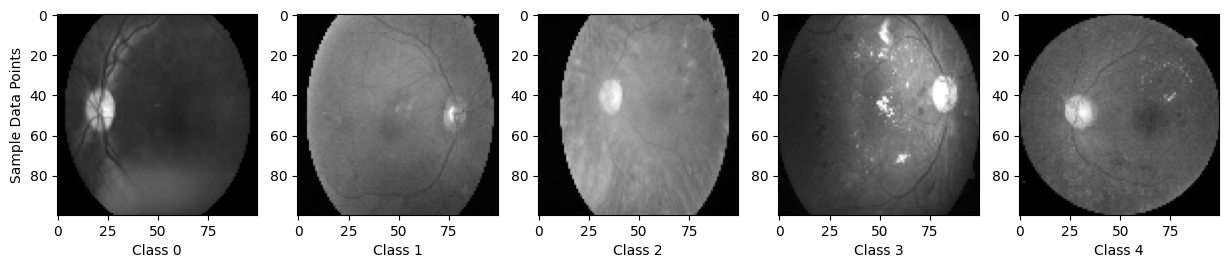

In [13]:
plots_per_class = 2
img_size = 100
visualize_imgs(train_df,plots_per_class,'gray',img_size)

#### Still we can't differentiate much here, so we have to explore for further pre-processing to differentiate between classes.

## Pre-Processing

#### Considering the pictures above we can see that the pictures are not uniforemly captured as technicians traveled to th rureal areas to capture images. Thus we can see there is non-uniforemd shape of the pictures.
#### So we try to remove those unnecessary black borders from the images and crop the image to take up the entirity of the image.

In [14]:
def crop_img(img, percentage):
    
    img_arr = np.array(img)
    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    
    threshold = img_gray > 0.1 * np.mean(img_gray[img_gray != 0])
    row_sums = np.sum(threshold, axis=1)
    col_sums = np.sum(threshold, axis=0)
    
    rows = np.where(row_sums > img_arr.shape[1] * percentage)[0]
    cols = np.where(col_sums > img_arr.shape[0] * percentage)[0]
    
    min_row, min_col = np.min(rows), np.min(cols)
    max_row, max_col = np.max(rows), np.max(cols)
    
    crop_img = img_arr[min_row : max_row + 1, min_col : max_col + 1]
    
    return Image.fromarray(crop_img)

In [15]:
def resize_maintain_aspect(img, desired_size):
    old_width, old_height = img.size
    aspect_ratio = old_width / old_height

    if aspect_ratio > 1:
        new_width = desired_size
        new_height = int(desired_size / aspect_ratio)
    else:
        new_height = desired_size
        new_width = int(desired_size * aspect_ratio)

    resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
    
    padded_image = Image.new("RGB", (desired_size, desired_size))
    x_offset = (desired_size - new_width) // 2
    y_offset = (desired_size - new_height) // 2
    padded_image.paste(resized_img, (x_offset, y_offset))
    
    return padded_image

In [16]:
def save_single(args):
    image_path, output_path_folder, percentage, output_size = args
    image = Image.open(image_path)
    
    # Display the image
    #plt.imshow(image)
    #plt.title('Original Image')
    #plt.show()
    
    croped_img = crop_img(image,percentage)
    image_resized = resize_maintain_aspect(croped_img, desired_size=output_size[0])
    
    #print(output_path_folder)
    #print(image_path)
    output_image_path = os.path.basename(image_path)
    # Save the resized image
    output_file_path = os.path.join(output_path_folder, output_image_path)
    #print(output_file_path)
    image_resized.save(output_file_path)

In [17]:
def fast_image_resize(df, output_path_folder, percentage, output_size=None):
    """Uses multiprocessing to make it fast"""
    if not output_size:
        warnings.warn("Need to specify output_size! For example: output_size=100")
        return

    if not os.path.exists(output_path_folder):
        os.makedirs(output_path_folder)
        
    jobs = []
    for df_item in range(len(df)):
        image_path = df.file_path.iloc[df_item]
        #print(image_path)
        job = (image_path, output_path_folder, percentage, output_size)
        jobs.append(job)
    
    """
    results = []
    for job in tqdm(jobs, total=len(jobs)):
        result = save_single(job)
        results.append(result)
    """
    with Pool() as p:
        list(tqdm(p.imap_unordered(save_single, jobs), total=len(jobs)))

In [18]:
percentage = 0.01
fast_image_resize(train_df, "/kaggle/working/train/images_resized_150/",percentage, output_size=(100, 100))

  0%|          | 0/3662 [00:00<?, ?it/s]/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
  0%|          | 1/3662 [00:00<09:30,  6.42it/s]/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
  0%|          | 2/3662 [00:00<14:15,  4.28it/s]/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)
/tmp/ipykernel_34/3153832717.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resam

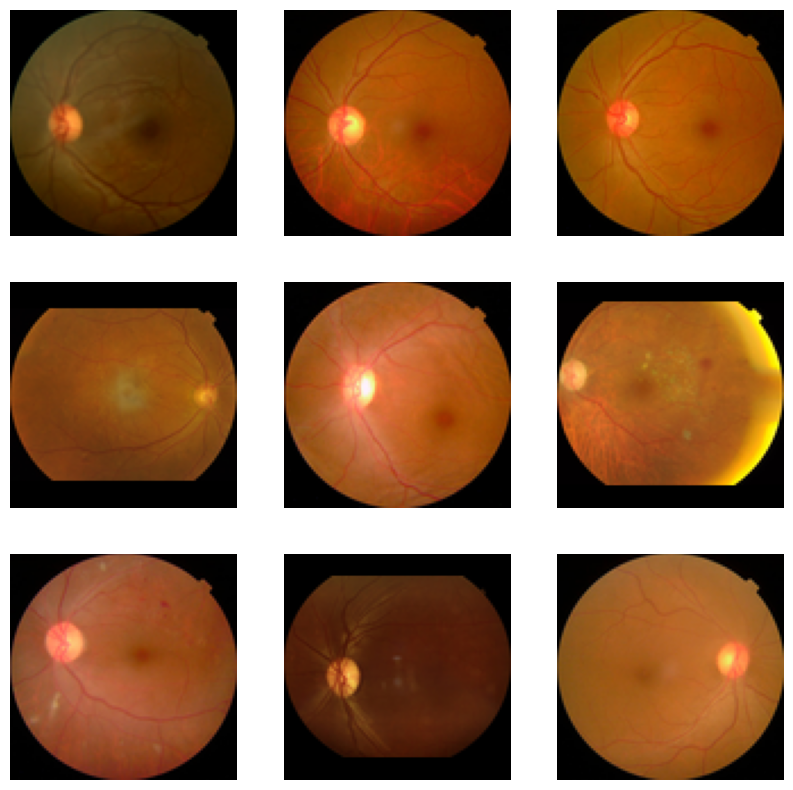

In [19]:
# Path to the directory containing the images
directory = "/kaggle/working/train/images_resized_150"

# Get a list of image filenames in the directory
image_files = os.listdir(directory)

# Define the number of images to display
num_images_to_display = 9

# Display the first few images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    # Check if there are more images to display
    if i < len(image_files):
        # Load the image
        img_path = os.path.join(directory, image_files[i])
        img = mpimg.imread(img_path)
        
        # Display the image
        ax.imshow(img)
        ax.axis('off')  # Hide axis
    else:
        # If there are no more images, remove the axis
        ax.axis('off')

plt.show()

## Model Implementation - Ensambling 
* EfficientNet_b5
* seresnext101_32x4d
* seresnext50_32x4d
* inception_v4
* inception_resnet_v2


In [20]:
class BlindnessDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, augmentations=None, max_count=None, test=False):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        #self.augmentations = augmentations
        self.max_count = max_count
        self.test = test
        
        if not test:
            self.class_counts = self.annotations['diagnosis'].value_counts().sort_index()
        else:
            self.class_counts = None
        
        if max_count:
            self.oversample(max_count)
    
    def oversample(self, max_count): ## Over sampling classes to balance
        samples = []
        for diagnosis in self.class_counts.index:
            class_samples = self.annotations[self.annotations['diagnosis'] == diagnosis]
            oversampled_class = class_samples.sample(max_count, replace=True)
            samples.append(oversampled_class)
        self.annotations = pd.concat(samples).reset_index(drop=True)
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0] + '.png')
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        if self.test:
            return image
                
        label = int(self.annotations.iloc[idx, 1])
        return image, label

In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [22]:
csv_file = '/kaggle/input/aptos2019-blindness-detection/train.csv'
pros_img_dir = '/kaggle/working/train/images_resized_150'

In [23]:
## Loading the dataset for determination of the class counts
temp_dataset = BlindnessDataset(csv_file, pros_img_dir, transform=transform)
class_counts = temp_dataset.class_counts
max_count = class_counts.max()


In [25]:
dataset = BlindnessDataset(csv_file, pros_img_dir, transform=transform, max_count=max_count)

In [26]:
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, stratify=dataset.annotations.iloc[:, 1])
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

In [27]:
def lr_schedule(epoch):
    if epoch < 10:
        return 5e-4
    elif epoch < 16:
        return 1e-4
    elif epoch < 22:
        return 1e-5
    else:
        return 1e-3

In [28]:
def train_model(model_name,input_size,train_loader,valid_loader, model_save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = select_model(model_name,input_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    def lambda_epoch(epoch):
        return lr_schedule(epoch)
    
    def quadratic_weighted_kappa(y_true, y_pred):
        return cohen_kappa_score(y_true, y_pred, weights='quadratic')
    
    scheduler = LambdaLR(optimizer,lr_lambda = lambda_epoch)
    best_kappa = 0.0
    
    for epoch in range(25):
        model.train()
        for images, labels in train_loader:
            if isinstance(images, Image.Image):  # Check if the image is a PIL image
                transform = transforms.ToTensor()
                images = transform(images)
            else:
                images = images
                
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
        
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels_epoch = []
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs,labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_labels_epoch.extend(labels.cpu().numpy())
                val_preds.extend(preds.cpu().numpy())
        
        #val_predictions.append(val_preds)
        #val_labels.append(val_labels_epoch)
        
        kappa = quadratic_weighted_kappa(val_labels_epoch, val_preds)
        print(f"Epoch {epoch+1}/{25}, Validation Loss: {val_loss / len(valid_loader)}")
        print(f"Validation QWK: {kappa}")
        
        if kappa > best_kappa:
            best_kappa = kappa
            best_model = model.state_dict()
            
    model.load_state_dict(best_model)
    torch.save(model.state_dict(), model_save_path)
    return model_save_path

In [29]:
# Parameters
save_dir = '/kaggle/working/models'
os.makedirs(save_dir, exist_ok=True)


In [30]:
def select_model(model_name, input_size):
    if model_name == 'efficientnet_b5':
        return timm.create_model('efficientnet_b5', pretrained=True, num_classes=5, in_chans=3)
    elif model_name == 'inception_resnet_v2':
        return timm.create_model('inception_resnet_v2', pretrained=True, num_classes=5, in_chans=3)
    elif model_name == 'inception_v4':
        return timm.create_model('inception_v4', pretrained=True, num_classes=5, in_chans=3)
    elif model_name == 'seresnext50_32x4d':
        return timm.create_model('seresnext50_32x4d', pretrained=True, num_classes=5, in_chans=3)
    elif model_name == 'seresnext101_32x4d':
        return timm.create_model('seresnext101_32x4d', pretrained=True, num_classes=5, in_chans=3)
    else:
        raise ValueError(f"Unknown model name {model_name}")

In [31]:
models_to_train = [
    ('efficientnet_b5', 512),
]
for model_name, input_size in models_to_train:
    model_save_path = os.path.join(save_dir, f"{model_name}.pth")
    train_model(model_name, input_size, train_loader, val_loader, model_save_path)

model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

Epoch 1/25, Validation Loss: 3.4631942447863127
Validation QWK: 0.3870258383727323
Epoch 2/25, Validation Loss: 2.315940847522334
Validation QWK: 0.5631935047361298
Epoch 3/25, Validation Loss: 1.7176148912362885
Validation QWK: 0.6563990731906774
Epoch 4/25, Validation Loss: 1.3491093181727225
Validation QWK: 0.7328918322295805
Epoch 5/25, Validation Loss: 1.055284645473748
Validation QWK: 0.7842489329478177
Epoch 6/25, Validation Loss: 0.8995928455863083
Validation QWK: 0.8012618296529969
Epoch 7/25, Validation Loss: 0.7238807971017402
Validation QWK: 0.8407452740378076
Epoch 8/25, Validation Loss: 0.6558373167849424
Validation QWK: 0.856754921928038
Epoch 9/25, Validation Loss: 0.5532645622366353
Validation QWK: 0.8834754364596021
Epoch 10/25, Validation Loss: 0.48097135205017894
Validation QWK: 0.8875611080934275
Epoch 11/25, Validation Loss: 0.4653243846014926
Validation QWK: 0.904456862477852
Epoch 12/25, Validation Loss: 0.4536485187055772
Validation QWK: 0.9029605263157895
Epoc

In [32]:
models_to_train = [
    ('seresnext101_32x4d', 512),
]
for model_name, input_size in models_to_train:
    model_save_path = os.path.join(save_dir, f"{model_name}.pth")
    train_model(model_name, input_size, train_loader, val_loader, model_save_path)

model.safetensors:   0%|          | 0.00/196M [00:00<?, ?B/s]

Epoch 1/25, Validation Loss: 1.4978900750478108
Validation QWK: 0.3472255875938939
Epoch 2/25, Validation Loss: 1.3534223782388788
Validation QWK: 0.5705637533106318
Epoch 3/25, Validation Loss: 1.2223684223074662
Validation QWK: 0.6829330608073583
Epoch 4/25, Validation Loss: 1.1283103541324013
Validation QWK: 0.7311544544016868
Epoch 5/25, Validation Loss: 1.0381423078085248
Validation QWK: 0.791413527744026
Epoch 6/25, Validation Loss: 0.9510356700211241
Validation QWK: 0.8061238314591519
Epoch 7/25, Validation Loss: 0.8809550728714257
Validation QWK: 0.8567208271787297
Epoch 8/25, Validation Loss: 0.8084174572375783
Validation QWK: 0.8736926790024135
Epoch 9/25, Validation Loss: 0.7442261900818139
Validation QWK: 0.8857752868961836
Epoch 10/25, Validation Loss: 0.683533813869744
Validation QWK: 0.8933280063923292
Epoch 11/25, Validation Loss: 0.6731003193478835
Validation QWK: 0.9043851414778061
Epoch 12/25, Validation Loss: 0.6573899879790189
Validation QWK: 0.8927381745502998
Epo

In [33]:
models_to_train = [
    ('seresnext50_32x4d', 512),
]
for model_name, input_size in models_to_train:
    model_save_path = os.path.join(save_dir, f"{model_name}.pth")
    train_model(model_name, input_size, train_loader, val_loader, model_save_path)

model.safetensors:   0%|          | 0.00/111M [00:00<?, ?B/s]

Epoch 1/25, Validation Loss: 1.5987386954458136
Validation QWK: 0.10595326213386913
Epoch 2/25, Validation Loss: 1.5779673802225214
Validation QWK: 0.19566170026292729
Epoch 3/25, Validation Loss: 1.5554862064227724
Validation QWK: 0.2832995267072346
Epoch 4/25, Validation Loss: 1.5377851410915977
Validation QWK: 0.356333917104495
Epoch 5/25, Validation Loss: 1.5119777332272446
Validation QWK: 0.41140819964349373
Epoch 6/25, Validation Loss: 1.4900255475127906
Validation QWK: 0.46902226524685386
Epoch 7/25, Validation Loss: 1.4645428406564813
Validation QWK: 0.5264443630145352
Epoch 8/25, Validation Loss: 1.443828076647039
Validation QWK: 0.5969069593414817
Epoch 9/25, Validation Loss: 1.415304792554755
Validation QWK: 0.6151537884471118
Epoch 10/25, Validation Loss: 1.392061292079457
Validation QWK: 0.6482043500252909
Epoch 11/25, Validation Loss: 1.386204443479839
Validation QWK: 0.6249363867684479
Epoch 12/25, Validation Loss: 1.3842674263736658
Validation QWK: 0.6603678508440414
Ep

In [34]:
models_to_train = [
    ('inception_v4', 512),
]
for model_name, input_size in models_to_train:
    model_save_path = os.path.join(save_dir, f"{model_name}.pth")
    train_model(model_name, input_size, train_loader, val_loader, model_save_path)

model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

Epoch 1/25, Validation Loss: 2.1140803224162052
Validation QWK: 0.10439420878841754
Epoch 2/25, Validation Loss: 2.0158426719799376
Validation QWK: 0.3727464876289942
Epoch 3/25, Validation Loss: 1.555972891941405
Validation QWK: 0.5286814005463124
Epoch 4/25, Validation Loss: 1.4343498004110236
Validation QWK: 0.6225281602002503
Epoch 5/25, Validation Loss: 1.2844800175281994
Validation QWK: 0.6649649010848755
Epoch 6/25, Validation Loss: 1.1857476192608214
Validation QWK: 0.7403970095385408
Epoch 7/25, Validation Loss: 1.1709229527858265
Validation QWK: 0.7635855764347385
Epoch 8/25, Validation Loss: 1.084721096774988
Validation QWK: 0.7829787234042553
Epoch 9/25, Validation Loss: 1.0747553016010083
Validation QWK: 0.8213027019971283
Epoch 10/25, Validation Loss: 1.0148104648841054
Validation QWK: 0.8296639629200464
Epoch 11/25, Validation Loss: 1.0830612945974918
Validation QWK: 0.8240764660294497
Epoch 12/25, Validation Loss: 1.0418056552870232
Validation QWK: 0.8356697819314642
Ep

In [35]:
models_to_train = [
    ('inception_resnet_v2', 512),
]
for model_name, input_size in models_to_train:
    model_save_path = os.path.join(save_dir, f"{model_name}.pth")
    train_model(model_name, input_size, train_loader, val_loader, model_save_path)

model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

Epoch 1/25, Validation Loss: 1.5686106995532387
Validation QWK: 0.07887628309022154
Epoch 2/25, Validation Loss: 1.525715905323363
Validation QWK: 0.13272415762421474
Epoch 3/25, Validation Loss: 1.4821955739406116
Validation QWK: 0.24087316522393676
Epoch 4/25, Validation Loss: 1.4553099536059195
Validation QWK: 0.31475239823697176
Epoch 5/25, Validation Loss: 1.3606653088017513
Validation QWK: 0.4215308370044053
Epoch 6/25, Validation Loss: 1.3180911101792987
Validation QWK: 0.5840244434744652
Epoch 7/25, Validation Loss: 1.2852716487750673
Validation QWK: 0.6254681647940075
Epoch 8/25, Validation Loss: 1.227204284124207
Validation QWK: 0.6847995466779997
Epoch 9/25, Validation Loss: 1.1848231616773104
Validation QWK: 0.7213761985335589
Epoch 10/25, Validation Loss: 1.1507802208264668
Validation QWK: 0.7427438765397141
Epoch 11/25, Validation Loss: 1.179812462706315
Validation QWK: 0.7519282008133501
Epoch 12/25, Validation Loss: 1.2027225389815213
Validation QWK: 0.7491582491582491
